# Advanced Functionality in PyJAGS

This notebook demonstrates some of the advanced features in PyJAGS. These include:
* Multicore support for parallel simulation of multiple Markov chains
* Saving sample MCMC chains to and restoring from HDF5 files
* Functionality to merge samples along iterations or across chains so that sampling can be resumed in consecutive chunks until convergence criteria are satisfied
* Connectivity to the Bayesian analysis and visualization package Arviz


# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import arviz as az
import line_profiler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyjags as pj
import seaborn as sns
from sklearn import preprocessing
import time
import typing as tp
import xarray as xr
xr.set_options(display_style="html");

In [4]:
%load_ext line_profiler

# HDF5 File Name

PyJAGS supports saving and loading of MCMC samples to and from HDF5 files.

In [5]:
hdf_5_filename = 'mcmc_samples_from_log_sv_model.hdf5'

# Read Dataset

We consider daily data on the S&P500 equity index obtained from Yahoo! Finance.

In [6]:
data_filename = os.path.join('data', 'SPY.csv')
df = pd.read_csv(data_filename)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df['Log Return'] = np.log(df['Close']).diff()
df['Adjusted Log Return'] = np.log(df['Adj Close']).diff()
df.dropna(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Log Return,Adjusted Log Return
6869,2020-05-11,290.339996,294.000000,289.880005,292.500000,292.500000,79514200,0.000205,0.000205
6870,2020-05-12,293.790009,294.239990,286.519989,286.670013,286.670013,95870800,-0.020133,-0.020133
6871,2020-05-13,286.059998,287.190002,278.959991,281.600006,281.600006,144721100,-0.017844,-0.017844
6872,2020-05-14,278.950012,285.109985,272.989990,284.970001,284.970001,121977900,0.011896,0.011896
6873,2020-05-15,282.369995,286.329987,281.339996,286.279999,286.279999,111146300,0.004586,0.004586


Select a subset of the data

In [7]:
df = df[df['Date'].between('2006-01-01', '2010-12-31')].copy()

In [8]:
log_returns = df['Log Return'].values
adjusted_log_returns = df['Adjusted Log Return'].values
demeaned_log_returns = log_returns - log_returns.mean()
dates = df['Date']

# Visualizing Returns

## Cumulative Returns

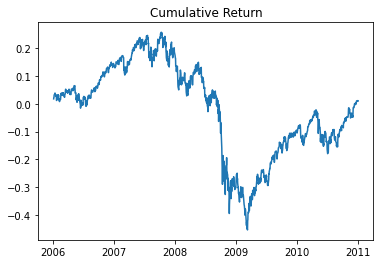

In [9]:
plt.plot(dates, np.exp(log_returns.cumsum()) - 1.0);
plt.title('Cumulative Return');

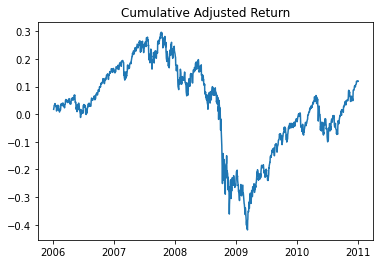

In [10]:
plt.plot(dates, np.exp(adjusted_log_returns.cumsum()) - 1.0);
plt.title('Cumulative Adjusted Return');

## Returns

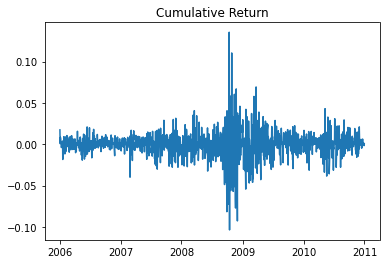

In [11]:
plt.plot(dates, log_returns);
plt.title('Cumulative Return');

We observe volatility clustering. High absolute returns are likely followed by high absolute returns, whereas low moderate returns in either direction are likely followed by moderate absolute returns.

# Stochastic Volatity Model

## Stochastic Process

We construct a model that incorporates volatility as a latent persistent stochastic process in order to address volatility clustering in the data. Here we model log-volatility as an AR(1) process. Since we are interested in estimating the dynamics in volatility rather than the mean, we subtract off the mean from log returns and set the expected log return to 0 in the model.

$
\begin{align*}
v_t & = \phi_v \cdot v_{t-1} + \sigma_v \cdot \eta_t, \text{ with } \eta_t \stackrel{\text{i.i.d.}}{\sim} N(0, 1) & \text{ log volatility }    \\
r_t & = \exp \left( \frac{1}{2} v_t \right) \cdot \epsilon_t, \text{ with } \epsilon_t \stackrel{\text{i.i.d.}}{\sim} N(0, 1) & \text{ log return }
\end{align*}
$  

## Priors

We use the following priors:  

$
\begin{align*}
\phi_v & \sim U(0, 1) \\
\sigma_v & \sim U(0, 1) \\
v_1 & \sim N(0, 10)
\end{align*}
$

## Bayesian Model in JAGS

Define the JAGS model

In [12]:
jags_model_string = '''
model {
    phi_v ~ dunif(0.0, 1.0)
    sigma_v ~ dunif(0.0, 1.0)
    tau_v = 1.0/sigma_v^2

    # treat the first h as a parameter to estimate
    v[1] ~ dnorm(0.0, 0.01)
    
    # observe each data point
    for (t in 2:length(r)) {
        v[t] ~ dnorm(phi_v * v[t-1] , tau_v)
        r[t] ~ dnorm(0.0, exp(-v[t]))
    }
}'''

Construct the data dictionary

In [13]:
jags_data \
    = {'r': demeaned_log_returns}

Construct JAGS Model

In [14]:
jags_model \
    = pj.Model(code=jags_model_string, 
               data=jags_data, 
               chains=4, 
               adapt=5000, 
               )

adapting: iterations 4568 of 20000, elapsed 0:00:09, remaining 0:00:31
adapting: iterations 7040 of 20000, elapsed 0:00:14, remaining 0:00:27
adapting: iterations 11980 of 20000, elapsed 0:00:23, remaining 0:00:16
adapting: iterations 17112 of 20000, elapsed 0:00:33, remaining 0:00:06
adapting: iterations 20000 of 20000, elapsed 0:00:38, remaining 0:00:00
adapting: iterations 20000 of 20000, elapsed 0:00:38, remaining 0:00:00


Draw 10000 iterations from each of the chains in the JAGS Model

In [15]:
start_time = time.time()
samples_1 = jags_model.sample(iterations=10000)
single_core_time = time.time() - start_time

sampling: iterations 5048 of 40000, elapsed 0:00:10, remaining 0:01:08
sampling: iterations 10216 of 40000, elapsed 0:00:20, remaining 0:00:57
sampling: iterations 15408 of 40000, elapsed 0:00:29, remaining 0:00:47
sampling: iterations 18024 of 40000, elapsed 0:00:35, remaining 0:00:42
sampling: iterations 23232 of 40000, elapsed 0:00:44, remaining 0:00:32
sampling: iterations 28476 of 40000, elapsed 0:00:54, remaining 0:00:22
sampling: iterations 33740 of 40000, elapsed 0:01:04, remaining 0:00:12
sampling: iterations 38992 of 40000, elapsed 0:01:14, remaining 0:00:02
sampling: iterations 40000 of 40000, elapsed 0:01:16, remaining 0:00:00


This is slow. To speed it up, run each of the four chains on a different core in parallel. To this end, we construct a new JAGS model instance with the argument 'threads=4'. Since we do not want to throw away the iterations already sampled, we are going to initialize the new JAGS model instance at the last iteration of the previous samples

### Extraction of the Most Recent Iteration of Sampled Values to Resume Sampling in a New Model Instance

In [16]:
jags_init = \
    pj.extract_final_iteration_from_samples_for_initialization(samples_1, 
                                                               variable_names=['phi_v', 'sigma_v', 'v'])

### Use Multiple Processes to Sample from Markov Chains in Parallel

Construct JAGS model where each chain is run on a different CPU core

In [17]:
jags_model \
    = pj.Model(code=jags_model_string, 
               data=jags_data, 
               chains=4, 
               adapt=5000, 
               threads=4, 
               init=jags_init, 
               chains_per_thread=1
               )

adapting: iterations 9045 of 20000, elapsed 0:00:09, remaining 0:00:11
adapting: iterations 20000 of 20000, elapsed 0:00:12, remaining 0:00:00


Draw another 10000 iterations from each chain, this time in parallel

In [18]:
start_time = time.time()
samples_2 = jags_model.sample(iterations=10000)
multi_core_time = time.time() - start_time

sampling: iterations 8286 of 40000, elapsed 0:00:09, remaining 0:00:34
sampling: iterations 19717 of 40000, elapsed 0:00:14, remaining 0:00:14
sampling: iterations 29523 of 40000, elapsed 0:00:19, remaining 0:00:07
sampling: iterations 31493 of 40000, elapsed 0:00:24, remaining 0:00:07
sampling: iterations 40000 of 40000, elapsed 0:00:28, remaining 0:00:00


Sampling on four CPU cores in parallel is much faster.

In [19]:
print(f'multicore speedup = {single_core_time / multi_core_time}')

multicore speedup = 2.6182029694494107


### Merge Consecutive Samples to Enable Sampling in Chunks until a Convergence Criterion is Satisfied

Merge consecutive draws of the two samples

In [20]:
merged_samples_1_and_2 = pj.merge_consecutive_chains((samples_1, samples_2))

### Discard Initial Samples as Burn-In

Discard the first 1000 iterations as burn-in

In [21]:
merged_samples_1_and_2_after_burn_in = pj.discard_burn_in_samples(merged_samples_1_and_2, burn_in=1000)

### Connectivity of PyJAGS with Arviz

Convert samples dictionary into Arviz object for visualization and chain diagnostics

In [22]:
idata = pj.convert_pyjags_samples_dict_to_arviz_inference_data(merged_samples_1_and_2_after_burn_in)

Plot Trace

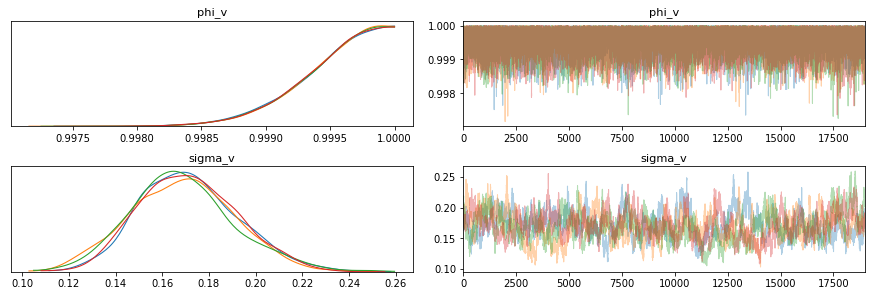

In [23]:
az.plot_trace(idata, 
              var_names=['phi_v', 
                         'sigma_v']);

Compute $\hat{R}$

In [24]:
az.rhat(idata, 
        var_names=['phi_v', 
                        'sigma_v'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    phi_v    float64 1.0
    sigma_v  float64 1.016

Compute effective sample size

In [25]:
ess = az.ess(idata, 
             var_names=['phi_v', 
                        'sigma_v'])
ess

<xarray.Dataset>
Dimensions:  ()
Data variables:
    phi_v    float64 1.18e+04
    sigma_v  float64 155.9

In [26]:
minimum_ess = min(value['data']
                  for key, value
                  in ess.to_dict()['data_vars'].items())
minimum_ess

155.92125509688282

The effective sample size for $\sigma_v$ is very low. Adaptively run the sampler until the ESS is at least 1000 for each variable.

### Sample Adaptively Until Each Variable has a Minimum Effective Sample Size of 1000 and $\hat{R} \in \left[ 0.99, 1.01 \right]$.

In [27]:
# criterion = pj.EffectiveSampleSizeCriterion(minimum_ess=1000, variable_names=['phi_v', 'sigma_v'])
# criterion = pj.RHatDeviationCriterion(maximum_rhat_deviation=0.01, variable_names=['phi_v', 'sigma_v'])
criterion = pj.EffectiveSampleSizeAndRHatCriterion(minimum_ess=1000, 
                                                   maximum_rhat_deviation=0.01, 
                                                   variable_names=['phi_v', 'sigma_v'])

Save the MCMC samples drawn so far at the end of each iteration in sample_until

In [28]:
def save_as_hdf5(samples: tp.Dict[str, np.ndarray], 
                 criterion_satisfied: bool, 
                 iterations: int):
    pj.save_samples_dictionary_to_file(
        filename=hdf_5_filename,
        samples=samples, 
        compression=False)

In [29]:
merged_samples_1_and_2_and_3_after_burn_in = \
    pj.sample_until(model=jags_model, 
                    criterion=criterion, 
                    previous_samples=merged_samples_1_and_2_after_burn_in, 
                    chunk_size=10000, 
                    verbose=True, 
                    iteration_function=save_as_hdf5)

minimum ess = 155.92125509688282
maximum rhat deviation = 0.0157527053432176
sampling: iterations 8739 of 40000, elapsed 0:00:09, remaining 0:00:32
sampling: iterations 18341 of 40000, elapsed 0:00:14, remaining 0:00:16
sampling: iterations 29970 of 40000, elapsed 0:00:19, remaining 0:00:06
sampling: iterations 36247 of 40000, elapsed 0:00:25, remaining 0:00:03
sampling: iterations 40000 of 40000, elapsed 0:00:27, remaining 0:00:00
minimum ess = 208.85550043575242
maximum rhat deviation = 0.018479487630998825
sampling: iterations 6405 of 40000, elapsed 0:00:08, remaining 0:00:44
sampling: iterations 15526 of 40000, elapsed 0:00:13, remaining 0:00:21
sampling: iterations 21920 of 40000, elapsed 0:00:19, remaining 0:00:15
sampling: iterations 29997 of 40000, elapsed 0:00:24, remaining 0:00:08
sampling: iterations 36436 of 40000, elapsed 0:00:29, remaining 0:00:03
sampling: iterations 40000 of 40000, elapsed 0:00:32, remaining 0:00:00
minimum ess = 321.1517498484205
maximum rhat deviation

Convert samples dictionary into Arviz object for visualization and chain diagnostics

In [30]:
idata = pj.convert_pyjags_samples_dict_to_arviz_inference_data(merged_samples_1_and_2_and_3_after_burn_in)

Plot Trace

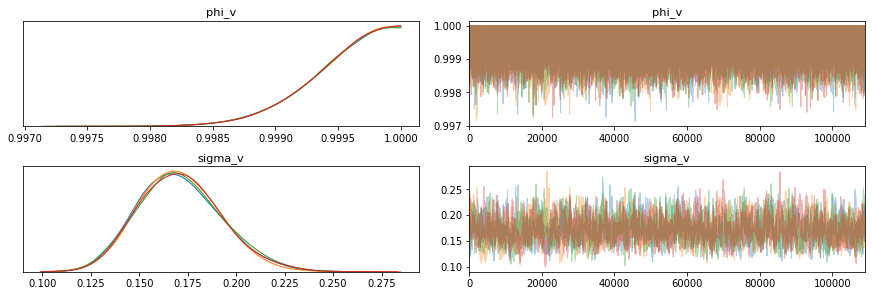

In [31]:
az.plot_trace(idata, 
              var_names=['phi_v', 
                         'sigma_v']);

Compute effective sample size

In [32]:
az.ess(idata, 
       var_names=['phi_v', 
                  'sigma_v'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    phi_v    float64 4.492e+04
    sigma_v  float64 1.017e+03

Compute $\hat{R}$ convergence diagnostic

In [33]:
az.rhat(idata, 
        var_names=['phi_v', 
                   'sigma_v'])

<xarray.Dataset>
Dimensions:  ()
Data variables:
    phi_v    float64 1.0
    sigma_v  float64 1.002

An R-Hat diagnostic significantly different from 1 indicates non-convergence. The small deviation here is ok.

### Saving Samples to HDF5 File

We might want to suspend the analysis and shutdown the notebook to free memory. In order to avoid having to run the MCMC sampling process again, we can save the samples generated by JAGS to a compressed HDF5 file.

In [34]:
pj.save_samples_dictionary_to_file(
        filename=hdf_5_filename,
        samples=merged_samples_1_and_2_and_3_after_burn_in, 
        compression=False)

### Loading Samples from HDF5 File to 

Once we are ready to resume our analysis, we can load the data from the HDF5 file as follows.

In [35]:
merged_samples_1_and_2_and_3_after_burn_in = \
    pj.load_samples_dictionary_from_file(hdf_5_filename)

### Plot the Mean of Filtered Volatility over Time

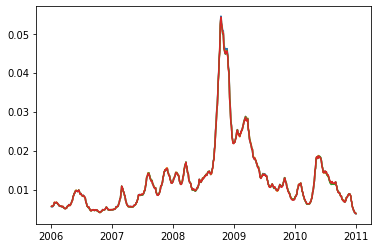

In [36]:
plt.plot(dates, np.exp(0.5 * merged_samples_1_and_2_and_3_after_burn_in['v']).mean(axis=1));

### Plot the Posterior of the Parameters

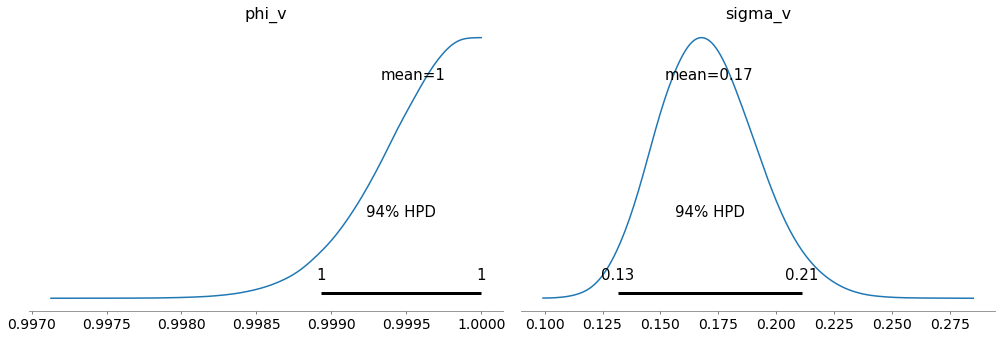

In [37]:
az.plot_posterior(idata, 
                  var_names=['phi_v', 
                             'sigma_v']);